In [1]:
import os
import cv2
import random
import pickle
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import shutil
import itertools
import imutils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

In [68]:
def preprocess(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    #new_image = thresh[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return new_image

In [69]:
datadir = ['brain_tumor_dataset/','augmented_brain_tumor_dataset/']
CATEGORIES = ['no','yes']
training_data_feature = []
training_data_label = []
IMG_SIZE = 120

def create_training_data():
    for DATADIR in datadir:
        for category in CATEGORIES:
            path = os.path.join(DATADIR, category)
            class_num = CATEGORIES.index(category) # categories for dog(0) and cat(1)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    image = preprocess(img_array)
                    new_array = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
                    new_array = new_array/255.0
                    training_data_feature.append(new_array)
                    training_data_label.append(class_num)
                except Exception as e:
                    pass
        
create_training_data()

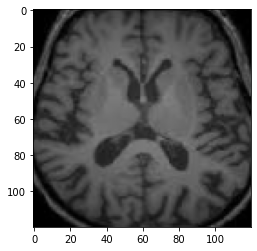

In [70]:
training_data_feature = np.array(training_data_feature)
training_data_label = np.array(training_data_label)
plt.imshow(training_data_feature[1], cmap="gray")
#training_data_feature[20].shape

In [71]:
X_train, X_test, y_train, y_test = train_test_split(training_data_feature,training_data_label, test_size=0.05)

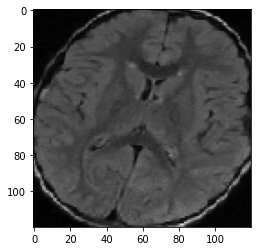

In [6]:
plt.imshow(X_test[0])

## CATDOG MODEL

In [143]:
model = Sequential()

model.add(Conv2D(64, (3,3), (1,1), input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) #to convert 3D feature map to 1D
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [144]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [145]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 1760 samples, validate on 441 samples
Epoch 1/10
1760/1760 [==============================] - 4s 2ms/sample - loss: 0.7458 - accuracy: 0.5528 - val_loss: 0.6004 - val_accuracy: 0.7166
Epoch 2/10
1760/1760 [==============================] - 3s 2ms/sample - loss: 0.5018 - accuracy: 0.7733 - val_loss: 0.4541 - val_accuracy: 0.8005
Epoch 3/10
1760/1760 [==============================] - 3s 2ms/sample - loss: 0.3791 - accuracy: 0.8335 - val_loss: 0.5263 - val_accuracy: 0.7460
Epoch 4/10
1760/1760 [==============================] - 3s 2ms/sample - loss: 0.3100 - accuracy: 0.8659 - val_loss: 0.4043 - val_accuracy: 0.8367
Epoch 5/10
1760/1760 [==============================] - 3s 2ms/sample - loss: 0.2488 - accuracy: 0.9000 - val_loss: 0.3402 - val_accuracy: 0.8685
Epoch 6/10
1760/1760 [==============================] - 3s 2ms/sample - loss: 0.1626 - accuracy: 0.9392 - val_loss: 0.4237 - val_accuracy: 0.8639
Epoch 7/10
1760/1760 [==============================] - 3s 2ms/sample - loss:

In [146]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

116/116 [==============================] - 0s 877us/sample - loss: 0.2795 - accuracy: 0.9138
Test loss: 0.2794686848747319
Test accuracy: 0.9137931


In [147]:
test_image = cv2.imread('test/arifk1.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0

test_image = np.array(new_array)
X_test[0]=test_image
ynew = model.predict_classes(X_test)
ynew[0]

array([0])

## CIFAR MODEL

In [148]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.4))
model5.add(Flatten())
model5.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(1, activation='sigmoid'))

In [149]:
model5.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [150]:
history = model5.fit(X_train,y_train,epochs=20,batch_size=64,validation_split=0.1)

Train on 1980 samples, validate on 221 samples
Epoch 1/20
1980/1980 [==============================] - 9s 5ms/sample - loss: 0.6415 - accuracy: 0.7227 - val_loss: 0.6913 - val_accuracy: 0.5566
Epoch 2/20
1980/1980 [==============================] - 7s 4ms/sample - loss: 0.3548 - accuracy: 0.8480 - val_loss: 0.7792 - val_accuracy: 0.6380
Epoch 3/20
1980/1980 [==============================] - 7s 4ms/sample - loss: 0.2835 - accuracy: 0.8818 - val_loss: 0.6727 - val_accuracy: 0.6833
Epoch 4/20
1980/1980 [==============================] - 7s 4ms/sample - loss: 0.2085 - accuracy: 0.9177 - val_loss: 1.0142 - val_accuracy: 0.6109
Epoch 5/20
1980/1980 [==============================] - 7s 4ms/sample - loss: 0.1635 - accuracy: 0.9424 - val_loss: 0.5094 - val_accuracy: 0.7873
Epoch 6/20
1980/1980 [==============================] - 7s 4ms/sample - loss: 0.1206 - accuracy: 0.9581 - val_loss: 0.6521 - val_accuracy: 0.7421
Epoch 7/20
1980/1980 [==============================] - 7s 4ms/sample - loss:

In [151]:
scores = model5.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

116/116 [==============================] - 0s 1ms/sample - loss: 0.2780 - accuracy: 0.8966
Test loss: 0.2779964218237277
Test accuracy: 0.8965517


In [153]:
test_image = cv2.imread('test/arifk1.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0

test_image = np.array(new_array)
X_test[0]=test_image
ynew = model5.predict_classes(X_test)
ynew[0]

array([0])

## INCEPTIONV3

In [179]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions, preprocess_input

modelINCEPTION = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    #input_shape=(IMG_SIZE,IMG_SIZE,3)
)

In [23]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions, preprocess_input

'''last_layer = modelINCEPTION.get_layer('mixed10')

last_output = last_layer.output

z = Flatten()(last_output)

z = Dense(1024, activation = 'relu')(z) 

z = Dropout(0.2)(z)

z= Dense(1, activation = 'sigmoid')(z)

model2 = Model(modelINCEPTION.input, z)'''

model = Sequential()
model.add(InceptionV3(include_top=False,pooling='max', weights="imagenet"))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(X_train,y_train,epochs=10,batch_size=64,validation_split=0.1)

Train on 1980 samples, validate on 221 samples
Epoch 1/10
1980/1980 [==============================] - 13s 7ms/sample - loss: 0.9818 - accuracy: 0.6343 - val_loss: 0.8399 - val_accuracy: 0.6697
Epoch 2/10
1980/1980 [==============================] - 4s 2ms/sample - loss: 0.4340 - accuracy: 0.8091 - val_loss: 0.6730 - val_accuracy: 0.7647
Epoch 3/10
1980/1980 [==============================] - 4s 2ms/sample - loss: 0.3751 - accuracy: 0.8455 - val_loss: 1.2230 - val_accuracy: 0.7511
Epoch 4/10
1980/1980 [==============================] - 4s 2ms/sample - loss: 0.3468 - accuracy: 0.8374 - val_loss: 0.7884 - val_accuracy: 0.7647
Epoch 5/10
1980/1980 [==============================] - 4s 2ms/sample - loss: 0.3322 - accuracy: 0.8611 - val_loss: 0.8756 - val_accuracy: 0.7602
Epoch 6/10
1980/1980 [==============================] - 4s 2ms/sample - loss: 0.2874 - accuracy: 0.8843 - val_loss: 1.1768 - val_accuracy: 0.7466
Epoch 7/10
1980/1980 [==============================] - 4s 2ms/sample - loss

In [26]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

116/116 [==============================] - 0s 2ms/sample - loss: 1.2514 - accuracy: 0.7155
Test loss: 1.2514001912084118
Test accuracy: 0.7155172


In [39]:
test_image = cv2.imread('test/3.png')
#test_image = cv2.imread('test/3.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0
test_image = np.array(new_array)
X_test[0]=test_image
ynew = model.predict_classes(X_test)
ynew[0]

array([1])

## RESNET


In [40]:
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image

In [75]:
modelRes = Sequential()
modelRes.add(ResNet50(include_top=False,pooling='avg', weights="imagenet"))
modelRes.add(Flatten())
modelRes.add(Dense(1024, activation='relu'))
modelRes.add(Dropout(0.2))
modelRes.add(Dense(1, activation='sigmoid'))
#modelRes.layers[0].trainable = False
for i in range(len(modelRes.layers)):
        modelRes.layers[i].trainable = False
modelRes.layers[-1].trainable=True

# Compile model 
modelRes.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
modelRes.fit(X_train,y_train,validation_split=0.2, epochs=15)

Train on 1760 samples, validate on 441 samples
Epoch 1/15
1760/1760 [==============================] - 13s 7ms/sample - loss: 0.6703 - accuracy: 0.6045 - val_loss: 0.6924 - val_accuracy: 0.5351
Epoch 2/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.4862 - accuracy: 0.7847 - val_loss: 0.6942 - val_accuracy: 0.4694988 - accuracy: 0. - ETA: 
Epoch 3/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.4073 - accuracy: 0.8364 - val_loss: 0.7031 - val_accuracy: 0.4921
Epoch 4/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.3535 - accuracy: 0.8676 - val_loss: 0.6943 - val_accuracy: 0.4762 - loss: 0.3552 - accuracy
Epoch 5/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.3332 - accuracy: 0.8727 - val_loss: 0.7047 - val_accuracy: 0.4921
Epoch 6/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.3066 - accuracy: 0.8699 - val_loss: 0.6944 - val_accuracy: 0.4762
Epoch 7/15
1760/1760 [==

In [77]:
scores = modelRes.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

116/116 [==============================] - 0s 3ms/sample - loss: 0.6877 - accuracy: 0.6121
Test loss: 0.6877233509359688
Test accuracy: 0.61206895


In [54]:
test_image = cv2.imread('test/3.png')
test_image = cv2.imread('test/8.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0
test_image = np.array(new_array)
X_test[0]=test_image
ynew = model.predict_classes(X_test)
ynew[0]

array([0])

### VGG16

In [78]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image

In [90]:
modelVGG16 = Sequential()
modelVGG16.add(VGG16(include_top=False,pooling='avg'))
modelVGG16.add(Flatten())
modelVGG16.add(Dense(1024, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(1, activation='sigmoid'))
#modelRes.layers[0].trainable = False
for i in range(len(modelVGG16.layers)):
        modelVGG16.layers[i].trainable = False
modelVGG16.layers[-1].trainable=True

# Compile model 
modelVGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
modelVGG16.fit(X_train,y_train,validation_split=0.2, epochs=15)

Train on 1760 samples, validate on 441 samples
Epoch 1/15
1760/1760 [==============================] - 9s 5ms/sample - loss: 0.6567 - accuracy: 0.6159 - val_loss: 0.6187 - val_accuracy: 0.7188
Epoch 2/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.6057 - accuracy: 0.6824 - val_loss: 0.5779 - val_accuracy: 0.7120
Epoch 3/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.5613 - accuracy: 0.7557 - val_loss: 0.5370 - val_accuracy: 0.7778
Epoch 4/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.5366 - accuracy: 0.7631 - val_loss: 0.5152 - val_accuracy: 0.7778
Epoch 5/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.5154 - accuracy: 0.7744 - val_loss: 0.4864 - val_accuracy: 0.8458
Epoch 6/15
1760/1760 [==============================] - 7s 4ms/sample - loss: 0.5023 - accuracy: 0.7898 - val_loss: 0.4744 - val_accuracy: 0.8050
Epoch 7/15
1760/1760 [==============================] - 7s 4ms/sample - loss:

In [92]:
scores = modelVGG16.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

116/116 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.86 - 0s 4ms/sample - loss: 0.3872 - accuracy: 0.8707
Test loss: 0.3872038259588439
Test accuracy: 0.87068963


## TEST

In [89]:
test_image = cv2.imread('test/3.png')
test_image = cv2.imread('test/8.jpg')
test_image = preprocess(test_image)
new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
new_array = new_array/255.0
test_image = np.array(new_array)
X_test[0]=test_image
ynew = model.predict_classes(X_test)
ynew[0]

array([0])